### import data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
alameda = pd.read_csv("/content/drive/My Drive/cp101project3_data/ARB_ASSR_ALAMEDA.csv")

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (9,21,22,33,34,40,42,45,53,68,168,175,177,187,188) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
alameda

,SA_PROPERTY_ID,SA_SCM_ID,MM_STATE_CODE,MM_MUNI_NAME,MM_FIPS_STATE_CODE,MM_FIPS_MUNI_CODE,MM_FIPS_COUNTY_NAME,SA_PARCEL_NBR_PRIMARY,SA_PARCEL_NBR_REFERENCE,SA_PARCEL_ACCOUNT_NBR,SA_PARCEL_NBR_ALT,SA_PARCEL_NBR_PREVIOUS,SA_PARCEL_NBR_CHANGE_YR,SA_YR_APN_ADDED,SA_OWNER_1,SA_OWNER_1_FIRST,SA_OWNER_1_MID,SA_OWNER_1_LAST,SA_OWNER_1_SUF,SA_OWNER_1_SP_FIRST,SA_OWNER_1_SP_MID,SA_OWNER_1_SP_SUF,SA_OWNER_1_GROUP,SA_OWNER_1_ET_FLAG,SA_OWNER_1_TRUST_FLAG,SA_OWNER_1_TYPE,SA_OWNER_2,SA_OWNER_2_FIRST,SA_OWNER_2_MID,SA_OWNER_2_LAST,SA_OWNER_2_SUF,SA_OWNER_2_SP_FIRST,SA_OWNER_2_SP_MID,SA_OWNER_2_SP_SUF,SA_OWNER_2_GROUP,SA_OWNER_2_ET_FLAG,SA_OWNER_2_TRUST_FLAG,SA_OWNER_2_TYPE,SA_OWNERSHIP_STATUS_CODE,SA_COMPANY_FLAG,...,SA_NBR_BATH_3QTR,SA_NBR_BATH_FULL,SA_NBR_BATH_BSMT_HALF,SA_NBR_BATH_BSMT_FULL,SA_NBR_BATH_DQ,SA_NBR_BEDRMS,SA_NBR_RMS,SA_NBR_STORIES,SA_NBR_UNITS,SA_PATIO_PORCH_CODE,SA_POOL_CODE,SA_PRIVACY_CODE,SA_ROOF_CODE,SA_SQFT,SA_SQFT_ASSR_TOT,SA_SQFT_DQ,SA_STRUCTURE_CODE,SA_STRUCTURE_NBR,SA_VIEW_CODE,SA_YR_BLT,SA_YR_BLT_EFFECT,SR_UNIQUE_ID,SR_UNIQUE_ID_NOVAL,SA_DATE_TRANSFER,SA_VAL_TRANSFER,SA_DOC_NBR_FMT,SA_DATE_NOVAL_TRANSFER,SA_DOC_NBR_NOVAL,PROCESS_ID,SA_X_COORD,SA_Y_COORD,SA_GEO_QLTY_CODE,SA_CENSUS_TRACT,SA_CENSUS_BLOCK_GROUP,CORE_BASED_STATISTICAL_AREA_CODE,MINOR_CIVIL_DIVISION_CODE,FIPS_PLACE_CODE,SA_INACTIVE_PARCEL_FLAG,SA_SHELL_PARCEL_FLAG,FILLER
0,38146934,33,CA,ALAMEDA,6,1,ALAMEDA,018 035500900,NaN,NaN,NaN,000O035500900,2011.0,2011.0,W P CO 843-1-2-3,W P CO 843-1-2-3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Y,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,145032,122.307539,37.795023,0,982000.0,1.0,41860.0,92230.0,53000.0,NaN,NaN,NaN
1,38146935,33,CA,ALAMEDA,6,1,ALAMEDA,018 035501000,NaN,NaN,NaN,000O035501000,2011.0,2011.0,CITY OF OAKLAND,CITY OF OAKLAND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CO,Y,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,145032,122.314487,37.807953,0,981900.0,1.0,41860.0,92230.0,53000.0,NaN,NaN,NaN
2,38146936,33,CA,ALAMEDA,6,1,ALAMEDA,018 037500100,NaN,NaN,NaN,000O037500100,2011.0,2011.0,EAST BAY MUNICIPAL UTILITY DISTRICT,EAST BAY MUNICIPAL UTILITY DISTRICT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CO,Y,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,145032,122.310801,37.808592,0,981900.0,1.0,41860.0,92230.0,53000.0,NaN,NaN,NaN
3,38146937,33,CA,ALAMEDA,6,1,ALAMEDA,018 037500302,NaN,NaN,NaN,000O037500302,2011.0,2011.0,S P CO 872-1-2C-9,S P CO 872-1-2C-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,"LEONARD,SHIRLEY",SHIRLEY,NaN,LEONARD,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,Y,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,0.0,NaN,NaN,NaN,145032,122.310639,37.808585,0,981900.0,1.0,41860.0,92230.0,53000.0,NaN,NaN,NaN
4,38146949,33,CA,ALAMEDA,6,1,ALAMEDA,018 038500100,NaN,NaN,NaN,000O038500100,2011.0,2011.0,CITY OF OAKLAND,CITY OF OAKLAND,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CO,Y,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0,NaN,NaN,NaN,389479287.0,0,19681203.0,0.0,0000133593,NaN,NaN,145032,122.301122,37.795091,0,982000.0,1.0,41860.0,92230.0,53000.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448178,156790920,33,CA,ALAMEDA,6,1,ALAMEDA,985 010204700,NaN,NaN,NaN,NaN,2013.0,2013.0,"HAMID,KHALIQ D & YASMEEN",KHALIQ,D,HAMID,NaN,YASMEEN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,Na

In [ ]:
## Impute address for searching online for properties
alameda['address'] = alameda['SA_SITE_HOUSE_NBR'].astype(str)+ " " +  alameda['SA_SITE_STREET_NAME'] + " " + alameda['SA_SITE_SUF'] + " " + alameda['SA_SITE_CITY'] + ", " + alameda['SA_SITE_ZIP'].astype(str)

**Add Tax/sq ft**

In [ ]:
 ## 'SA_SQFT'-The total square footage of the living area of all structures on the property                     
alameda['SA_TAX_PER_SQFT'] = alameda['SA_TAX_VAL'] / alameda['SA_SQFT']

In [ ]:
## tax value = 0 -> number = 19842 
len(alameda[alameda['SA_TAX_VAL'] == 0])

19842

In [ ]:
## SA_LOTSIZE = 0 -> number = 36110
len(alameda[alameda['SA_SQFT'] == 0])

36110

In [ ]:
## SA_LOTSIZE = NA -> number = 969
sum(alameda['SA_TAX_VAL'].isna())

969

In [ ]:
## SA_SQFT = NA -> number = 548
sum(alameda['SA_SQFT'].isna())

548

In [ ]:
## 18714 NA value in 'SA_TAX_PER_SQFT'
sum(alameda['SA_TAX_PER_SQFT'].isna())

18714

**Filter column 'USE_CODE_MUNI' (property type)**

In [ ]:
single_family_alameda = alameda[alameda['USE_CODE_STD'] == 'RSFR']

In [ ]:
## Relevant columns for filtering by USE_CODE_MUNI
relevant = ['SA_PARCEL_NBR_PRIMARY','SA_CENSUS_TRACT', 'SA_CENSUS_BLOCK_GROUP', 'SA_SQFT', 'SA_LOTSIZE', 'SA_TAX_VAL', 'SA_TAX_PER_SQFT','USE_CODE_MUNI', 'USE_CODE_STD', 'address']

# We can see two things: USE_CODE_STD does not normalize to normal homes
# The reason why some are not taxed is because if CODE_MUNI is 1890, then its - Planned Development Tract, Common Area or use
# http://www.acgov.org/MS/prop/useCodeList.aspx
# same goes for 1690: SFR Detached Site Condominium , Common Area or use
# if it is 11, then we run into problems; like for APN 429 001408800.
# only exception is index #430647	at address: 828 ARLINGTON AVE BERKELEY, 94707 which should have been taxed


## For ease, I think we should remove those with MUNI codes 1890 (since it is planned development) and maybe 1690.

reduced = single_family_alameda[relevant]
missing_tax = reduced[reduced['SA_TAX_PER_SQFT'].isna() | reduced['SA_TAX_PER_SQFT'] == 0]
len(missing_tax) #37 households that are marked as 'RSFR' still do not have taxes

40

In [ ]:
## Single Family Residence (USE_CODE_MUNI >= 1000 and < 2000 for single family residence)

single_family_alameda = single_family_alameda[(single_family_alameda['USE_CODE_MUNI'] >= 1000) & (single_family_alameda['USE_CODE_MUNI'] < 2000)]
len(single_family_alameda)

294643

Clean (NA, 0, inf)

In [ ]:
clean_alameda = single_family_alameda[(single_family_alameda['SA_TAX_PER_SQFT'].notna()) & 
                                      (single_family_alameda['SA_TAX_PER_SQFT'] > 0) & 
                                      (single_family_alameda['SA_TAX_PER_SQFT'] != float("inf"))]

In [ ]:
len(clean_alameda)

291221

**Group by unit of analysis (block)**

In [ ]:
sum(clean_alameda['SA_TAX_PER_SQFT'] == 0) #No missing values

0

In [ ]:
## groupby census tract and census block group
block_mean = clean_alameda.groupby(['SA_CENSUS_TRACT','SA_CENSUS_BLOCK_GROUP'])[['SA_TAX_VAL']].mean()
block_mean

SA_TAX_VAL
SA_CENSUS_TRACT SA_CENSUS_BLOCK_GROUP              
352202.0        1.0                     8641.803571
353001.0        2.0                    10965.233000
354001.0        1.0                    16700.568000
400100.0        1.0                    12965.162073
400200.0        1.0                     8590.520985
...                                             ...
451703.0        2.0                     6313.442328
451704.0        1.0                     6583.238501
                2.0                     4107.954545
                3.0                     3651.510695
982000.0        1.0                     2143.742500

[1017 rows x 1 columns]

In [ ]:
clean_alameda.groupby(['SA_CENSUS_TRACT','SA_CENSUS_BLOCK_GROUP'])[['SA_TAX_PER_SQFT']].mean()

SA_TAX_PER_SQFT
SA_CENSUS_TRACT SA_CENSUS_BLOCK_GROUP                 
352202.0        1.0                           4.065001
353001.0        2.0                           4.004994
354001.0        1.0                           4.577223
400100.0        1.0                           4.423249
400200.0        1.0                           4.410773
...                                                ...
451703.0        2.0                           2.712466
451704.0        1.0                           2.566051
                2.0                           2.332215
                3.0                           2.735050
982000.0        1.0                           2.485353

[1017 rows x 1 columns]

In [ ]:
np.mean(clean_alameda['SA_TAX_PER_SQFT'])

3.0930896611946026

**GINI INDEX VIA 2 METHODS:**

In [ ]:
example = clean_alameda[(clean_alameda['SA_CENSUS_TRACT'] == 352202.0) & (clean_alameda['SA_CENSUS_BLOCK_GROUP'] == 1.0)]['SA_TAX_PER_SQFT']

In [ ]:
def gini_individual(series):
    """Calculate the Gini coefficient of a list."""
    ## based on https://github.com/oliviaguest/gini?fbclid=IwAR1BiepdlOzWEx5zc5ryCn7FBW8fyw3EvRzdd1ide0VQt4ZVV-NDU3NfRLE
    ## and http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    sort_series = series.sort_values()
    index = np.arange(1, len(sort_series) + 1)
    n = len(sort_series)
    return ((np.sum((2 * index - n  - 1) * sort_series)) / (n * np.sum(sort_series))) #Gini coefficient

In [ ]:
clean_alameda.groupby(['SA_CENSUS_TRACT','SA_CENSUS_BLOCK_GROUP'])['SA_TAX_PER_SQFT'].apply(gini_individual)
# .sort_values(ascending = False)[0:20]

SA_CENSUS_TRACT  SA_CENSUS_BLOCK_GROUP
352202.0         1.0                      0.286344
353001.0         2.0                      0.208335
354001.0         1.0                      0.279451
400100.0         1.0                      0.266936
400200.0         1.0                      0.368135
                                            ...   
451703.0         2.0                      0.180103
451704.0         1.0                      0.206237
                 2.0                      0.254012
                 3.0                      0.244144
982000.0         1.0                      0.347317
Name: SA_TAX_PER_SQFT, Length: 1017, dtype: float64

In [ ]:
def pairwiseSum(lst): 
    pair_sum = []
    for i in range(len(lst)-1): 
        # adding the alternate numbers 
        Sum = lst[i] + lst[i + 1] 
        pair_sum.append(Sum)
    return np.array(pair_sum)
def pairwiseDiff(lst): 
    pair_diff = []
    for i in range(len(lst)-1): 
        # adding the alternate numbers 
        diff = lst[i+1] -lst[i] 
        pair_diff.append(diff)
    return np.array(pair_diff)

In [ ]:
def gini_group(series):
    """Calculate the Gini coefficient of a list."""
    sort_series = np.array(series.sort_values())
    n = len(sort_series)
    if n <= 10:
        group_num = n
        share_house = np.repeat(1/n, n)
    else:
        group_num = 10
        share_house = np.repeat(0.1, 10)
      
    groups = np.array_split(sort_series, group_num)
    tax_level = np.array([np.mean(arr) for arr in groups])
    share_aggregate_tax = tax_level / sum(tax_level)
    cumulative_tax = np.cumsum(share_aggregate_tax)
    cumulative_house = np.cumsum(share_house)
    A = pairwiseSum(cumulative_tax)
    B = pairwiseDiff(cumulative_house)
    AB = A * B
    sum_AB = sum(AB)
    gini = 1 - sum_AB

    if n == 1:
      gini = 0
    
    return gini

In [ ]:
gini_index_group = clean_alameda.groupby(['SA_CENSUS_TRACT','SA_CENSUS_BLOCK_GROUP'])['SA_TAX_PER_SQFT'].apply(gini_group)
pd.DataFrame(gini_index_group).to_csv('/content/drive/My Drive/cp101project3_data/gini_index_block.csv')
# .sort_values(ascending = False)[0:20]

**EXPLORING WHY FIRST 5 VALUES ARE DIFFERENT**

In [ ]:
clean_alameda.groupby(['SA_CENSUS_TRACT','SA_CENSUS_BLOCK_GROUP'])['SA_TAX_PER_SQFT'].apply(gini_group).sort_values(ascending = False)[0:20]

SA_CENSUS_TRACT  SA_CENSUS_BLOCK_GROUP
421300.0         4.0                      0.745170
441521.0         3.0                      0.623224
422800.0         1.0                      0.417211
400400.0         1.0                      0.387641
401300.0         1.0                      0.382669
400400.0         3.0                      0.376073
400200.0         1.0                      0.363903
                 2.0                      0.363176
450746.0         2.0                      0.362043
450605.0         2.0                      0.362002
403800.0         2.0                      0.361355
441523.0         2.0                      0.359626
400300.0         1.0                      0.359569
400400.0         2.0                      0.358196
441923.0         3.0                      0.357592
400300.0         4.0                      0.355594
405301.0         1.0                      0.355216
402800.0         1.0                      0.352397
982000.0         1.0                      0

In [ ]:
clean_alameda.groupby(['SA_CENSUS_TRACT','SA_CENSUS_BLOCK_GROUP'])['SA_TAX_PER_SQFT'].apply(gini_individual).sort_values(ascending = False)[0:20]

SA_CENSUS_TRACT  SA_CENSUS_BLOCK_GROUP
421300.0         4.0                      0.817097
441521.0         3.0                      0.677782
422800.0         1.0                      0.415822
400400.0         1.0                      0.392922
403702.0         1.0                      0.385903
441523.0         2.0                      0.382086
400400.0         3.0                      0.381132
401300.0         1.0                      0.377693
450601.0         1.0                      0.368939
400200.0         1.0                      0.368135
                 2.0                      0.366534
450746.0         2.0                      0.366087
450605.0         2.0                      0.364996
403800.0         2.0                      0.363081
400300.0         1.0                      0.361427
400400.0         2.0                      0.361413
405301.0         1.0                      0.359913
400300.0         4.0                      0.358949
403300.0         2.0                      0

**Comparing both functions, why different:**

In [ ]:
dif_blocks = [(422800.0, 2.0), (450602.0, 1.0), (403701.0, 1.0),(403400.0, 2.0), (425101.0, 2.0)] #blocks in order: 2, 1, 1, 2, 2
block_counts = clean_alameda.groupby(['SA_CENSUS_TRACT','SA_CENSUS_BLOCK_GROUP'])[['SA_TAX_PER_SQFT']].count()
block_counts.loc[dif_blocks] #fix if # of households = 1 > it was all equal to 1

block_counts.loc[(441521.0,3.0)] # same with difference of .5 (row 2 comparison)

SA_TAX_PER_SQFT    426
Name: (441521.0, 3.0), dtype: int64

In [ ]:
block_counts.loc[(421300.0,4.0)] #Difference of .7 (row 1 comparison) caused by a lot of more households binned into only 10 groups

SA_TAX_PER_SQFT    302
Name: (421300.0, 4.0), dtype: int64

In [ ]:
#check gini_individual for these groups > it was originally 0

clean_alameda.groupby(['SA_CENSUS_TRACT','SA_CENSUS_BLOCK_GROUP'])['SA_TAX_PER_SQFT'].apply(gini_individual).loc[dif_blocks]

SA_CENSUS_TRACT  SA_CENSUS_BLOCK_GROUP
422800.0         2.0                      0.0
450602.0         1.0                      0.0
403701.0         1.0                      0.0
403400.0         2.0                      0.0
425101.0         2.0                      0.0
Name: SA_TAX_PER_SQFT, dtype: float64

In [ ]:
##Check bottom 20 for differences:
clean_alameda.groupby(['SA_CENSUS_TRACT','SA_CENSUS_BLOCK_GROUP'])['SA_TAX_PER_SQFT'].apply(gini_group).sort_values(ascending = True)[0:20]

SA_CENSUS_TRACT  SA_CENSUS_BLOCK_GROUP
403400.0         2.0                      0.000000
450602.0         1.0                      0.000000
403701.0         1.0                      0.000000
425101.0         2.0                      0.000000
422800.0         2.0                      0.000000
433400.0         6.0                      0.063099
                 4.0                      0.067540
440335.0         1.0                      0.073461
450743.0         2.0                      0.077321
451401.0         1.0                      0.078305
450102.0         3.0                      0.080126
450751.0         1.0                      0.081864
441927.0         2.0                      0.083215
450752.0         1.0                      0.084458
442302.0         2.0                      0.084644
428700.0         1.0                      0.085116
451101.0         5.0                      0.086180
433400.0         5.0                      0.087260
450701.0         4.0                      0

In [ ]:
clean_alameda.groupby(['SA_CENSUS_TRACT','SA_CENSUS_BLOCK_GROUP'])['SA_TAX_PER_SQFT'].apply(gini_individual).sort_values(ascending = True)[0:20]

SA_CENSUS_TRACT  SA_CENSUS_BLOCK_GROUP
403701.0         1.0                      0.000000
403400.0         2.0                      0.000000
450602.0         1.0                      0.000000
422800.0         2.0                      0.000000
425101.0         2.0                      0.000000
433400.0         6.0                      0.055340
                 4.0                      0.060438
440335.0         1.0                      0.066567
450743.0         2.0                      0.067322
441927.0         2.0                      0.068746
450102.0         3.0                      0.074116
450751.0         1.0                      0.075295
451401.0         1.0                      0.075582
450752.0         1.0                      0.077774
428700.0         1.0                      0.079313
451101.0         5.0                      0.080711
433400.0         5.0                      0.080823
440335.0         2.0                      0.082214
451101.0         2.0                      0

**Calculating Lost Assesed Value:**

In [ ]:
clean_alameda = single_family_alameda[(single_family_alameda['SA_TAX_PER_SQFT'].notna()) & 
                                      (single_family_alameda['SA_TAX_PER_SQFT'] > 0) & 
                                      (single_family_alameda['SA_TAX_PER_SQFT'] != float("inf"))]
#Remove homes with assesed value == to 0
clean_alameda[clean_alameda['SA_VAL_ASSD'] == 0]
clean_alameda = clean_alameda.drop([306630])


# Subset into two different datasets:

#1) Data that have not been sold or have been sold before 1978 (SA_TRANSFER_DATE)

clean_alameda['SA_DATE_TRANSFER'] = (clean_alameda['SA_DATE_TRANSFER']).astype('str')
clean_alameda['SA_TRANSFER_YEAR'] = clean_alameda['SA_DATE_TRANSFER'].str[:4]
clean_alameda['SA_TRANSFER_YEAR'] = clean_alameda['SA_TRANSFER_YEAR'].astype('float')
clean_alameda['1978_YR_DIF'] = clean_alameda['SA_TRANSFER_YEAR'] - 1978
clean_alameda['2013_YR_DIF'] = 2013 - clean_alameda['SA_TRANSFER_YEAR']

## get rid of those transfer in 2014
clean_alameda = clean_alameda[clean_alameda['2013_YR_DIF'] != -1]

no_sale = clean_alameda[(clean_alameda['SA_TRANSFER_YEAR'] < 1978) | (clean_alameda['SA_TRANSFER_YEAR'].isnull())]
#no_sale[used_col].sort_values(by = 'SA_TRANSFER_YEAR', ascending = False)

#2) Data that have been sold between 1978 to 2013
sale = clean_alameda[(clean_alameda['SA_TRANSFER_YEAR'] >= 1978)]

In [ ]:
len(sale)

247077

In [ ]:
len(no_sale)

40241

In [ ]:
len(clean_alameda) == len(sale) + len(no_sale)


True

In [ ]:
#Making sure those sold are not null
sum(sale['SA_TRANSFER_YEAR'].isnull())

0

In [ ]:
#Making sure
sum(sale['SA_VAL_ASSD'].isnull())

0

In [ ]:
sum(no_sale['SA_VAL_ASSD'].isnull())

0

**Importing Alfred's House Indices**

In [ ]:
house_indices = pd.read_csv("/content/drive/My Drive/cp101project3_data/alfredgraph.csv")
inflation = pd.read_csv("/content/drive/My Drive/cp101project3_data/inflation.csv")
house_indices = house_indices[['Rates', 'Year']]
inflation = inflation[['Period', 'Factor','Factor_year']].iloc[0:36,:]
house_indices.head()

,Rates,Year
0,NaN,1975
1,13%,1976
2,22%,1977
3,14%,1978
4,17%,1979


In [ ]:
inflation

,Period,Factor,Factor_year
0,1978,1.0000,1.000000
1,1979,1.0902,1.090200
2,1980,1.2351,1.132911
3,1981,1.3897,1.125172
4,1982,1.5137,1.089228
5,1983,1.5717,1.038317
6,1984,1.6312,1.037857
7,1985,1.6957,1.039541
8,1986,1.7601,1.037978
9,1987,1.7794,1.010965


In [ ]:
#Create dictionary for inflation
inflation_year = {}
inflation_fac = {}

for i in np.arange(len(inflation)):
  inflation_year[inflation['Period'][i]] = inflation['Factor_year'][i]
  inflation_fac[inflation['Period'][i]] = inflation['Factor'][i]
inflation_year

{1978: 1.0,
 1979: 1.0902,
 1980: 1.132911392,
 1981: 1.1251720509999998,
 1982: 1.089227891,
 1983: 1.0383167070000001,
 1984: 1.037857097,
 1985: 1.039541442,
 1986: 1.0379784159999998,
 1987: 1.010965286,
 1988: 1.044340789,
 1989: 1.044180165,
 1990: 1.046485261,
 1991: 1.061065695,
 1992: 1.030632136,
 1993: 1.029001171,
 1994: 1.027483589,
 1995: 1.026748445,
 1996: 1.02538787,
 1997: 1.033214661,
 1998: 1.017032773,
 1999: 1.016131516,
 2000: 1.026825295,
 2001: 1.033873289,
 2002: 1.0155251790000002,
 2003: 1.023757644,
 2004: 1.018812221,
 2005: 1.032549363,
 2006: 1.034166558,
 2007: 1.025401534,
 2008: 1.040805022,
 2009: 1.0009165629999999,
 2010: 1.0272058609999999,
 2011: 1.014982458,
 2012: 1.029607593,
 2013: 1.017418822}

In [ ]:
inflation_fac

{1978: 1.0,
 1979: 1.0902,
 1980: 1.2351,
 1981: 1.3897,
 1982: 1.5137,
 1983: 1.5717,
 1984: 1.6312,
 1985: 1.6957,
 1986: 1.7601,
 1987: 1.7794,
 1988: 1.8583,
 1989: 1.9404,
 1990: 2.0306,
 1991: 2.1546,
 1992: 2.2206,
 1993: 2.285,
 1994: 2.3478,
 1995: 2.4106,
 1996: 2.4718,
 1997: 2.5539,
 1998: 2.5974,
 1999: 2.6393,
 2000: 2.7101,
 2001: 2.8019,
 2002: 2.8454,
 2003: 2.9130000000000003,
 2004: 2.9678,
 2005: 3.0644,
 2006: 3.1691,
 2007: 3.2496,
 2008: 3.3822,
 2009: 3.3853,
 2010: 3.4774,
 2011: 3.5295,
 2012: 3.634,
 2013: 3.6973}

In [ ]:
### inflation from 1978 to 2013 is 3.6973

In [ ]:
#Convert rates to decimal for easier conversion
house_indices['Rates'] = house_indices['Rates'].str.rstrip('%').astype('float') / 100.0

years = house_indices['Year']
rates = house_indices['Rates']

#Create dictionary for future conversion
growth_rates = {}

for i in np.arange(len(years)):
  growth_rates[years[i]] = rates[i]


In [ ]:
def go_forward(value, rate):
  fwd_val = value*(1+rate)
  return fwd_val

def go_backward(value, rate):
  bck_val = value/(1+rate)
  return bck_val

def go_backward_years(values, year_diff, transfer, year_diff_2013): #since going backward by only 2%
    ## need['SA_TRANSFER_YEAR'] = transfer
    ## need['SA_VAL_ASSD'] = values
    ## need ['1978_YR_DIF'] or Year Transfer Diff = year_diff

    #USED TO STANDARDIZE PRICES BACK TO 1978 OR
    ##TO STANDARDIZE PRICES BACK TO TRANSFER DATE


  bck_val = []
  for i in np.arange(len(values)):
    if year_diff[i] == 0:  #Then it is at 1978
      bck_val = np.append(bck_val, values[i])
    #elif year_diff[i] < 0:
      #if < 0, then that means the house was sold before 1978, need to go forward to 1978
      #val_1978 = values[i] #initial value 
      #if transfer[i] <= 1975: #get prices in 1976

        #FIX CODE, if transfer is before 1975, then it does not matter. just go back to 1978 using 2% and then go forward to 2013.
        #for year in np.arange(transfer[i], 1976, 1):
            #13% is the rate used 
          #val_1978 = go_forward(val_1978, growth_rates[1976])
          #then go forward to 1978
        #for year in np.arange(1976, 1979, 1):
          #val_1978 = go_forward(val_1978, growth_rates[year])
      #else: #if between 1976 and 1978
        #for year in np.arange(transfer[i], 1979, 1):
          #val_1978 = go_forward(val_1978, growth_rates[year])
      #bck_val = np.append(bck_val, val_1978)
    else: 
      #no transfer
      if np.isnan(year_diff[i]) or year_diff[i] < 0:
        bck_val = np.append(bck_val, (values[i]/((1.02)**(35)))/inflation_fac[2013])
      else:
        #had transfer and year difference is positive
        bck_val = np.append(bck_val, (values[i]/(1.02)**(year_diff_2013[i])) / (inflation_fac[2013] / inflation_fac[2013-year_diff_2013[i]]))
        
  return bck_val

In [ ]:
used_col = ['SA_VAL_ASSD', 'SA_TRANSFER_YEAR','1978_YR_DIF','2013_YR_DIF']
no_sale[used_col].head()

,SA_VAL_ASSD,SA_TRANSFER_YEAR,1978_YR_DIF,2013_YR_DIF
169,29865.0,NaN,NaN,NaN
177,70357.0,NaN,NaN,NaN
182,29467.0,1974.0,-4.0,39.0
183,143012.0,NaN,NaN,NaN
184,31856.0,NaN,NaN,NaN


In [ ]:
def calc_value_without_prop13(df, bool_transfer):
  ## need['SA_TRANSFER_YEAR'] as an arr
  ## need['SA_VAL_ASSD'] as an arr
  # need ['1978_YR_DIF'] as an arr

  current_prices = []
  #1 ) NO TRANSFER (NULL OR TRANSFER BEFORE 1978)
  if (bool_transfer == False):
    #Go back to 1978 using assesed value by 2% each year 
    prices_1978 = go_backward_years(np.array(df['SA_VAL_ASSD']), np.array(df['1978_YR_DIF']), np.array(df['SA_TRANSFER_YEAR']), np.array(df['2013_YR_DIF']))

    #Go forward to 2014 using growth rates 
    for x in prices_1978:
      new_price = x
      #iterate through each year from 1979 to 2013 by using its corresponding growth rate
      #x is price starting from 1978 growing to year y 
      for year in np.arange(1979, 2014, 1):
        new_price = go_forward(new_price, growth_rates[year])*inflation_year[year]
      current_prices = np.append(current_prices, new_price)
    return current_prices
  else:
  #2 ) YES HAS TRANSFERS (HOUSE SOLD)
    #Only need to look from 2013 to transfer date 
    transfer_diff = np.array(2013 - df['SA_TRANSFER_YEAR'])
    #Go back to transfer date by 2% each year
    back_transfer_prices = go_backward_years(np.array(df['SA_VAL_ASSD']), np.array(df['1978_YR_DIF']), np.array(df['SA_TRANSFER_YEAR']), np.array(df['2013_YR_DIF'])) #transfer_dif will always be positive

    #Go forward to 2014 using growth rates 
    for (x,y) in zip(back_transfer_prices, np.array(df['SA_TRANSFER_YEAR'])):
      new_price = x
      #iterate through each year from transfer year to 2013 by using its corresponding growth rate
      #x is price starting from transfer year growing to year 2013
      for year in np.arange(y+1, 2014, 1):
        new_price = go_forward(new_price, growth_rates[year])*inflation_year[year]
      current_prices = np.append(current_prices, new_price)     
    
  return current_prices

In [ ]:
sale['LOST_VALUE'] = calc_value_without_prop13(sale, True) - np.array(sale['SA_VAL_ASSD'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
no_sale['LOST_VALUE'] = calc_value_without_prop13(no_sale, False)- np.array(no_sale['SA_VAL_ASSD'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
sale['LOST_VALUE'].head()

168    137129.326743
170    208788.945627
200     -7656.045670
201     35294.117570
202    125434.328113
Name: LOST_VALUE, dtype: float64

In [ ]:
sale[sale['LOST_VALUE'] < 0]['SA_TRANSFER_YEAR']

200       2002.0
205       2002.0
207       2006.0
374       2007.0
386       2004.0
           ...  
447901    2009.0
447902    2009.0
447912    2009.0
447945    2009.0
448000    2009.0
Name: SA_TRANSFER_YEAR, Length: 87275, dtype: float64

In [ ]:
sum(no_sale['LOST_VALUE'])

12238068531.110275

In [ ]:
sum(sale['LOST_VALUE'])

22787845631.23193

In [ ]:
totalRevLost = sum(sale['LOST_VALUE']) + sum(no_sale['LOST_VALUE'])
totalRevLost

35025914162.34221

In [ ]:
used_col = ['SA_VAL_ASSD', 'SA_TRANSFER_YEAR', 'WITHOUT_PROP13_VALUE', 'LOST_VALUE','SA_TAX_VAL']
sale['WITHOUT_PROP13_VALUE'] = calc_value_without_prop13(sale, True)
no_sale['WITHOUT_PROP13_VALUE'] = calc_value_without_prop13(no_sale, False)
no_sale[used_col].head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,SA_VAL_ASSD,SA_TRANSFER_YEAR,WITHOUT_PROP13_VALUE,LOST_VALUE,SA_TAX_VAL
169,29865.0,NaN,102850.519599,72985.519599,1153.08
177,70357.0,NaN,242298.811566,171941.811566,1837.10
182,29467.0,1974.0,101479.868107,72012.868107,1147.34
183,143012.0,NaN,492511.585765,349499.585765,2883.56
184,31856.0,NaN,109707.220905,77851.220905,986.76


In [ ]:
sum(no_sale['LOST_VALUE'] > 0) == len(no_sale)

True

In [ ]:
no_sale['TAX_RATE'] = no_sale['SA_TAX_VAL'] / no_sale['SA_VAL_ASSD']
sale['TAX_RATE'] = sale['SA_TAX_VAL'] / sale['SA_VAL_ASSD']
no_sale['LOST_TAX_VALUE'] = no_sale['LOST_VALUE'] * no_sale['TAX_RATE']
sale['LOST_TAX_VALUE'] = sale['LOST_VALUE'] * sale['TAX_RATE']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
def get_year(data):
  years = []
  for i in data:
    if np.isnan(i):
      years.append(35)
    elif i == 0:
      years.append(1)
    elif i <= 35 and i > 0:
      years.append(i)
    else:
      years.append(35)
  return years
sale['Transfered_Year'] = get_year(sale['2013_YR_DIF'])
no_sale['Transfered_Year'] = get_year(no_sale['2013_YR_DIF'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
sale['Average_Tax_Loss_per_year'] = sale['LOST_TAX_VALUE'] / sale['Transfered_Year']
no_sale['Average_Tax_Loss_per_year'] = no_sale['LOST_TAX_VALUE'] / no_sale['Transfered_Year']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
sale['Average_Tax_Loss_per_year_per_sqft'] = sale['Average_Tax_Loss_per_year'] / sale['SA_SQFT']
no_sale['Average_Tax_Loss_per_year_per_sqft'] = no_sale['Average_Tax_Loss_per_year'] / no_sale['SA_SQFT']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
sale['LOST_TAX_VALUE_PER_SQFT'] = sale['LOST_TAX_VALUE'] / sale['SA_SQFT']
no_sale['LOST_TAX_VALUE_PER_SQFT'] = no_sale['LOST_TAX_VALUE'] / no_sale['SA_SQFT']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
useful_col = ['SA_PROPERTY_ID','SA_CENSUS_TRACT', 'SA_CENSUS_BLOCK_GROUP', 'address','SA_X_COORD','SA_Y_COORD','SA_SQFT','SA_VAL_ASSD', 'SA_TRANSFER_YEAR', 'WITHOUT_PROP13_VALUE', 'LOST_VALUE','LOST_TAX_VALUE','LOST_TAX_VALUE_PER_SQFT','Average_Tax_Loss_per_year','Average_Tax_Loss_per_year_per_sqft','Transfered_Year']

In [ ]:
sale[useful_col].head()

,SA_PROPERTY_ID,SA_CENSUS_TRACT,SA_CENSUS_BLOCK_GROUP,address,SA_X_COORD,SA_Y_COORD,SA_SQFT,SA_VAL_ASSD,SA_TRANSFER_YEAR,WITHOUT_PROP13_VALUE,LOST_VALUE,LOST_TAX_VALUE,LOST_TAX_VALUE_PER_SQFT,Average_Tax_Loss_per_year,Average_Tax_Loss_per_year_per_sqft,Transfered_Year
168,38147876,403300.0,1.0,"59.0 8TH ST OAKLAND, 94607",122.264809,37.796407,1160.0,234638.0,1994.0,371767.326743,137129.326743,2456.496694,2.117670,129.289300,0.111456,19.0
170,38147880,403300.0,1.0,"709.0 FALLON ST OAKLAND, 94607",122.264825,37.796145,1278.0,152394.0,1982.0,361182.945627,208788.945627,4359.997200,3.411578,140.645071,0.110051,31.0
200,38147993,403300.0,2.0,"228.0 7TH ST OAKLAND, 94607",122.268734,37.797642,1359.0,309185.0,2002.0,301528.954330,-7656.045670,-128.171196,-0.094313,-11.651927,-0.008574,11.0
201,38147994,403300.0,2.0,"230.0 7TH ST OAKLAND, 94607",122.268812,37.797673,955.0,300000.0,2012.0,335294.117570,35294.117570,605.254116,0.633774,605.254116,0.633774,1.0
202,38147995,403300.0,2.0,"234.0 7TH ST OAKLAND, 94607",122.268889,37.797703,1160.0,240160.0,1993.0,365594.328113,125434.328113,2184.216118,1.882945,109.210806,0.094147,20.0


In [ ]:
no_sale[useful_col].head()

,SA_PROPERTY_ID,SA_CENSUS_TRACT,SA_CENSUS_BLOCK_GROUP,address,SA_X_COORD,SA_Y_COORD,SA_SQFT,SA_VAL_ASSD,SA_TRANSFER_YEAR,WITHOUT_PROP13_VALUE,LOST_VALUE,LOST_TAX_VALUE,LOST_TAX_VALUE_PER_SQFT,Average_Tax_Loss_per_year,Average_Tax_Loss_per_year_per_sqft,Transfered_Year
169,38147877,403300.0,1.0,"55.0 8TH ST OAKLAND, 94607",122.264731,37.796377,1402.0,29865.0,NaN,102850.519599,72985.519599,2817.952216,2.009952,80.512920,0.057427,35
177,38147889,403300.0,1.0,"714.0 OAK ST OAKLAND, 94607",122.265439,37.796403,2048.0,70357.0,NaN,242298.811566,171941.811566,4489.593104,2.192184,128.274089,0.062634,35
182,38147895,403300.0,2.0,"129.0 7TH ST OAKLAND, 94607",122.266729,37.796301,978.0,29467.0,1974.0,101479.868107,72012.868107,2803.924529,2.866998,80.112129,0.081914,35
183,38147896,403300.0,2.0,"125.0 7TH ST OAKLAND, 94607",122.266652,37.796271,1178.0,143012.0,NaN,492511.585765,349499.585765,7046.982250,5.982158,201.342350,0.170919,35
184,38147897,403300.0,2.0,"121.0 7TH ST OAKLAND, 94607",122.266574,37.796240,1613.0,31856.0,NaN,109707.220905,77851.220905,2411.491422,1.495035,68.899755,0.042715,35


In [ ]:
alameda_properties = pd.concat([sale[useful_col],no_sale[useful_col]]).reset_index().drop(columns=['index'])
alameda_properties

,SA_PROPERTY_ID,SA_CENSUS_TRACT,SA_CENSUS_BLOCK_GROUP,address,SA_X_COORD,SA_Y_COORD,SA_SQFT,SA_VAL_ASSD,SA_TRANSFER_YEAR,WITHOUT_PROP13_VALUE,LOST_VALUE,LOST_TAX_VALUE,LOST_TAX_VALUE_PER_SQFT,Average_Tax_Loss_per_year,Average_Tax_Loss_per_year_per_sqft,Transfered_Year
0,38147876,403300.0,1.0,"59.0 8TH ST OAKLAND, 94607",122.264809,37.796407,1160.0,234638.0,1994.0,3.717673e+05,1.371293e+05,2456.496694,2.117670,129.289300,0.111456,19.0
1,38147880,403300.0,1.0,"709.0 FALLON ST OAKLAND, 94607",122.264825,37.796145,1278.0,152394.0,1982.0,3.611829e+05,2.087889e+05,4359.997200,3.411578,140.645071,0.110051,31.0
2,38147993,403300.0,2.0,"228.0 7TH ST OAKLAND, 94607",122.268734,37.797642,1359.0,309185.0,2002.0,3.015290e+05,-7.656046e+03,-128.171196,-0.094313,-11.651927,-0.008574,11.0
3,38147994,403300.0,2.0,"230.0 7TH ST OAKLAND, 94607",122.268812,37.797673,955.0,300000.0,2012.0,3.352941e+05,3.529412e+04,605.254116,0.633774,605.254116,0.633774,1.0
4,38147995,403300.0,2.0,"234.0 7TH ST OAKLAND, 94607",122.268889,37.797703,1160.0,240160.0,1993.0,3.655943e+05,1.254343e+05,2184.216118,1.882945,109.210806,0.094147,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
287313,104767797,450745.0,2.0,"1509.0 MAPLE LEAF DR PLEASANTON, 94588",121.865684,37.680136,2788.0,918868.0,NaN,3.164442e+06,2.245574e+06,25868.081877,9.278365,739.088054,0.265096,35.0
287314,113580503,435200.0,1.0,"22610.0 VALLEY VIEW DR HAYWARD, 94541",122.049450,37.689587,3741.0,724077.0,NaN,2.493611e+06,1.769534e+06,21210.694171,5.669793,606.019833,0.161994,35.0
287315,126675730,450701.0,3.0,"6035.0 SYCAMORE TER PLEASANTON, 94566",121.878749,37.645575,4087.0,1425000.0,NaN,4.907483e+06,3.482483e+06,40142.548987,9.822009,1146.929971,0.280629,35.0
287316,151502188,442302.0,2.0,"40964.0 OLMSTEAD TER FREMONT, 94538",121.967357,37.532247,1428.0,602820.0,NaN,2.076020e+06,1.473200e+06,17627.426525,12.344136,503.640758,0.352690,35.0


In [ ]:
alameda_properties.to_csv('/content/drive/My Drive/cp101project3_data/tax_value_loss.csv')


### **Calculation**

In [ ]:
## Total tax value loss
sum(alameda_properties['LOST_TAX_VALUE'])

598094643.3838592

In [ ]:
## Average tax value loss
np.mean(alameda_properties['LOST_TAX_VALUE'])

2081.6469674154046

In [ ]:
## Average tax loss per sqft
np.mean(alameda_properties['LOST_TAX_VALUE_PER_SQFT'])

1.3017971061073694

In [ ]:
## total tax loss per sqft
sum(alameda_properties['Average_Tax_Loss_per_year'])

26678097.271928594

## Graph

In [ ]:
## total assessed value in 2013
total_val_2013 = sum(no_sale['SA_VAL_ASSD'])
assess_each_year = [total_val_2013]

for i in range(35):
  curr = (total_val_2013 / 1.02) / inflation_year[2013 - i]
  assess_each_year.append(curr)
  total_val_2013 = curr

len(assess_each_year)

36

In [ ]:
year_range = list(np.arange(1978,2014))
year_range.sort(reverse=True)
len(year_range)

36

In [ ]:
def calc_value_without_prop13_each_year(df):
  ## need['SA_TRANSFER_YEAR'] as an arr
  ## need['SA_VAL_ASSD'] as an arr
  # need ['1978_YR_DIF'] as an arr

  year_prices = []
  #Go back to 1978 using assesed value by 2% each year 
  prices_1978 = go_backward_years(np.array(df['SA_VAL_ASSD']), np.array(df['1978_YR_DIF']), np.array(df['SA_TRANSFER_YEAR']), np.array(df['2013_YR_DIF']))

  #Go forward to years using growth rates 
  for x in prices_1978:
    new_price = x
    single_price = []
    single_price.append(x)
    for year in np.arange(1979, 2014, 1):
      new_price = go_forward(new_price, growth_rates[year])*inflation_year[year]
      single_price.append(new_price)
    year_prices.append(single_price)
  return year_prices
  

In [ ]:
def calc_value_without_prop13_each_year_tax(df):
  ## need['SA_TRANSFER_YEAR'] as an arr
  ## need['SA_VAL_ASSD'] as an arr
  # need ['1978_YR_DIF'] as an arr

  year_prices = []
  #Go back to 1978 using assesed value by 2% each year 
  prices_1978 = go_backward_years(np.array(df['SA_VAL_ASSD']), np.array(df['1978_YR_DIF']), np.array(df['SA_TRANSFER_YEAR']), np.array(df['2013_YR_DIF']))

  #Go forward to years using growth rates 
  for x in range(len(prices_1978)):
    new_price = prices_1978[x]
    single_price = []
    single_price.append(prices_1978[x] * df['TAX_RATE'][x])
    for year in np.arange(1979, 2014, 1):
      new_price = go_forward(new_price, growth_rates[year])*inflation_year[year] * df['TAX_RATE'][x]
      single_price.append(new_price)
    year_prices.append(single_price)
  return year_prices
  

In [ ]:
no_sale = no_sale.reset_index().drop(columns=['index'])

In [ ]:
market_each_year_tax = list(np.sum(np.array(calc_value_without_prop13_each_year_tax(no_sale)),0))[::-1] 
market_each_year_tax

[55631877861716.18,
 25108467214011.86,
 12765991667471.615,
 6930837618733.862,
 3567933770716.8076,
 2145055261897.1597,
 1269436024671.9966,
 668247411200.6095,
 310425952887.1892,
 128010516676.35724,
 58766813951.713936,
 28647166212.769573,
 13951445887.041813,
 6209645198.167985,
 2560822392.527397,
 1204643524.1397493,
 567282080.4366413,
 276245523.02325994,
 141473655.7053782,
 74229792.66089278,
 39621913.7920905,
 21342660.974772938,
 11524623.513201209,
 6220162.675794602,
 3251595.2919053636,
 1471301.8293509586,
 740276.6650500379,
 427428.88548721996,
 250980.90256941097,
 152016.68846305498,
 97003.10539391273,
 65973.99333806752,
 62337.829526495276,
 518295.5168961125,
 15981182.640593313,
 12529013.448950268]

In [ ]:
market_each_year = list(np.sum(np.array(calc_value_without_prop13_each_year(no_sale)),0))

In [ ]:
market_year = market_each_year[::-1] 
market_year

[17245773055.11035,
 14868872851.433865,
 14441300697.97779,
 14976977223.547272,
 14727583239.290714,
 16912754991.43246,
 19117277869.409023,
 19220308564.497154,
 17050745330.357512,
 13425406159.033625,
 11765632113.330807,
 10945328694.862316,
 10167922963.538807,
 8627005615.357346,
 6775507602.809951,
 6061766876.829039,
 5418406669.923212,
 4994496787.041614,
 4822610514.988374,
 4744417949.923005,
 4711747085.668892,
 4672400114.750264,
 4579321671.282826,
 4403852878.868877,
 4007840105.5690165,
 3070611942.197927,
 2534689144.0007772,
 2321478714.5454116,
 2090222919.698998,
 1879174110.1214042,
 1724408527.7831497,
 1612401134.832796,
 1465659097.0100355,
 1184189884.323931,
 863853371.762672,
 677248408.7156247]

In [ ]:
np.mean(no_sale['TAX_RATE'])

0.02261342154835554

In [ ]:
each_year = pd.DataFrame(data = {'Year': year_range, 'Assessed_Value_Prop13': assess_each_year, "Value_without_prop13": market_year,
                                 'Assessed_Tax_Prop13': np.array(assess_each_year) * 0.0226, "Tax_without_prop13": np.array(market_year)*0.0226})
# each_year['Assessed_Value_Prop13'] = each_year['Assessed_Value_Prop13'].apply(lambda x: '{:.2f}'.format(x))
# each_year["Value_without_prop13"] = each_year["Value_without_prop13"].apply(lambda x: '{:.2f}'.format(x))

In [ ]:
each_year

,Year,Assessed_Value_Prop13,Value_without_prop13,Assessed_Tax_Prop13,Tax_without_prop13
0,2013,5.007705e+09,1.724577e+10,1.131741e+08,3.897545e+08
1,2012,4.825460e+09,1.486887e+10,1.090554e+08,3.360365e+08
2,2011,4.594802e+09,1.444130e+10,1.038425e+08,3.263734e+08
3,2010,4.438213e+09,1.497698e+10,1.003036e+08,3.384797e+08
4,2009,4.235947e+09,1.472758e+10,9.573239e+07,3.328434e+08
5,2008,4.149086e+09,1.691275e+10,9.376934e+07,3.822283e+08
6,2007,3.908255e+09,1.911728e+10,8.832656e+07,4.320505e+08
7,2006,3.736704e+09,1.922031e+10,8.444952e+07,4.343790e+08
8,2005,3.542404e+09,1.705075e+10,8.005833e+07,3.853468e+08
9,2004,3.363466e+09,1.342541e+10,7.601434e+07,3.034142e+08


In [ ]:
each_year.to_csv('/content/drive/My Drive/cp101project3_data/Property_value_tax_each_year.csv')


Text(0.5, 1.0, 'Property Value With and Without Prop 13 Per Year')

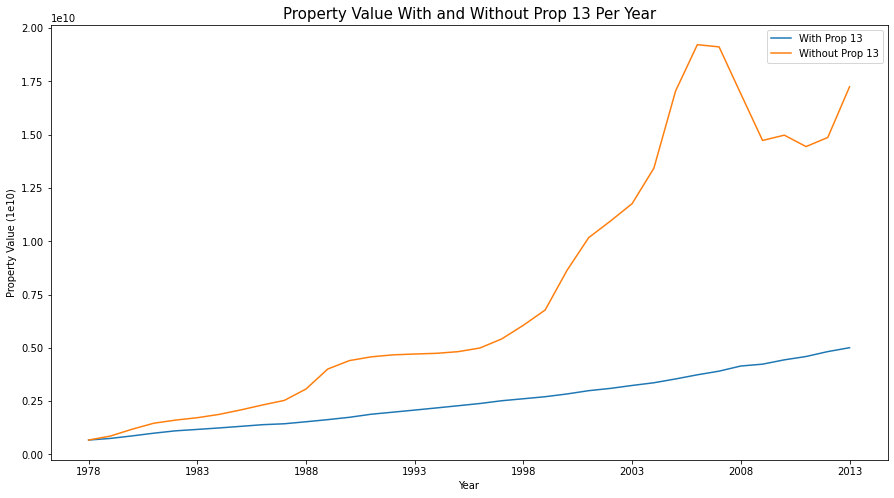

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(each_year['Year'], each_year['Assessed_Value_Prop13'], label= 'With Prop 13')
plt.plot(each_year['Year'], each_year['Value_without_prop13'], label= 'Without Prop 13')
plt.xlabel('Year')
plt.xticks(np.arange(1978, 2014,5))
plt.ylabel('Property Value (1e10)')
plt.legend()
plt.title("Property Value With and Without Prop 13 Per Year", fontsize=15)

Text(0.5, 1.0, 'Property Tax Value With and Without Prop 13 Per Year')

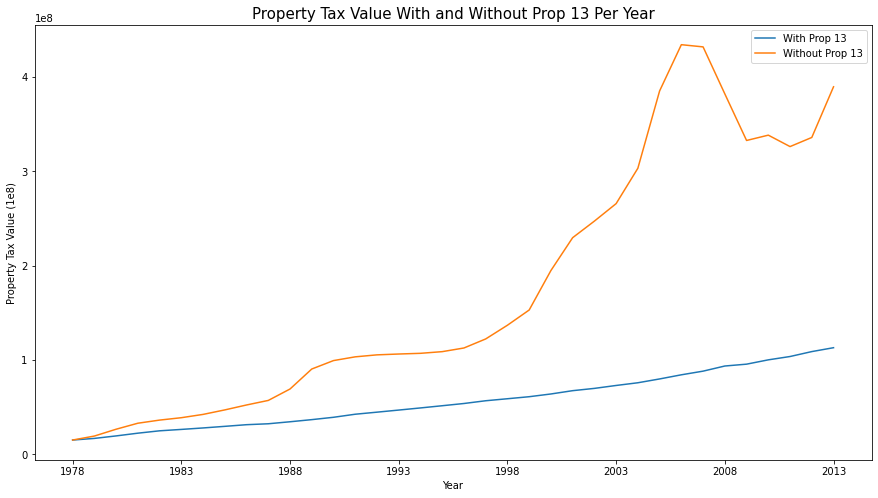

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,8))
plt.plot(each_year['Year'], each_year['Assessed_Tax_Prop13'], label= 'With Prop 13')
plt.plot(each_year['Year'], each_year['Tax_without_prop13'], label= 'Without Prop 13')
plt.xlabel('Year')
plt.xticks(np.arange(1978, 2014,5))
plt.ylabel('Property Tax Value (1e8)')
plt.legend()
plt.title("Property Tax Value With and Without Prop 13 Per Year", fontsize=15)